！！CHANGE DATA PATH ACCORDINGLY！！

This document contain code and results developed by BaiXi Zou(student number: 251194285) for ECE9039 Jane Street Machine Learning Project. 
*****
Version History

v1.01: created a NN

v1.02: Added a scoring system, same as the competition

v1.03: change output to resp only, code work until Model Evualuation section

v1.04: added 2 model, logistic regression, random forest. code will work until Logistic Regression Section

v1.05: reworked scoring system; updated NN model including early dropout prevent overfit; include data with weight = 0; now all sections are working

v1.06: added LSTM model, all sections are working

v1.07: Final version. Cleaned up code and added refernces

#Mount drive to colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


#Import Libraries & Set Seeds & Initialize TPU

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
import gc

pd.set_option('display.max_columns', 500)

#set all seeds for consistance result
seed_value = 1111
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
np.random.seed(seed_value)
import tensorflow as tf
tf.compat.v1.set_random_seed(seed_value)
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)


##Initialize tensorflow enviroment for TPU acceleration

In [ ]:
#Reference: TPU initialization script comes from the tensorflow website:
#Website URL: https://www.tensorflow.org/guide/tpu

#Use TPU in tensorflow
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

#create a TPUStrategy to distristue model to all avaliable TPU cores
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Initializing the TPU system: grpc://10.124.17.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.124.17.26:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


#Load and Preprocess data

In [ ]:
datapath = '/content/drive/MyDrive/train.csv'

#Use panda to load dataset
dataSet = pd.read_csv(datapath)

print('dataset memm usage before type conversion...')
dataSet.info()
#change data types to reduce memory usage
dataSet.feature_0 = dataSet.feature_0.astype(np.int8)
dataSet.date = dataSet.date.astype(np.int16)
dataSet.ts_id = dataSet.ts_id.astype(np.int32)

#convert data value over +/-0.0001 from float 64 to float 32
for i in dataSet:
        if dataSet[i].dtype == np.float64:
                if (((dataSet[i]<0.0001) & (dataSet[i]>-0.0001)).mean()) <0.001:
                    dataSet[i] = dataSet[i].astype(np.float32)

gc.collect()
print('dataset memm usage after type conversion...')
dataSet.info()

#drop data before day 85, drop day 294 data
dataSet = dataSet.query('date > 85').reset_index(drop = True)
dataSet = dataSet.query('date != 294').reset_index(drop = True)

#assemble stock id
dataSet['stock_id'] = dataSet['feature_41'] + dataSet['feature_42'] + dataSet['feature_43']
dataSet = dataSet.drop(['feature_41', 'feature_42', 'feature_43'], axis = 1)

#action = if all resp returns >0: , else: 0
dataSet['action'] =  ((dataSet['resp'] > 0 ).astype('int'))

#generate feature list to be used in generating X, Y
features = [c for c in dataSet.columns if 'feature' in c]
features.extend(['date', 'ts_id', 'stock_id', 'weight', 'action'])
resp_cols = ['resp']

#sort value based on date and order of tranction order
dataSet = dataSet.sort_values(['date', 'ts_id'], ascending = [True, True])

print('Data Preprocessing Done!')

dataset memm usage before type conversion...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float64(135), int64(3)
memory usage: 2.5 GB
dataset memm usage after type conversion...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float32(129), float64(6), int16(1), int32(1), int8(1)
memory usage: 1.3 GB
Data Preprocessing Done!


##Generate X & Y

In [ ]:
#X: vlaues in features(no resp), include action
X = dataSet[features]
# only resp as output as it is the only value needed in calcualting competition score
#convert resp to 0(negative return value) and 1(positive return value)
Y = np.stack([(dataSet[c] > 0).astype('int') for c in resp_cols]).T
Y = pd.DataFrame(data=Y, columns=["resp"])

print(X.shape)
print(Y.shape)

#no random split, last 13% data (about 50 days) is test data, simulate future data
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,
                                                Y, 
                                                test_size = 0.13,
                                                shuffle=False)

#generate test data frame with features
#replace resp value from 0 or 1 back to origonal values
test_df = pd.concat([Xtest, Ytest], axis = 1)
test_df['resp'] = dataSet['resp']
test_df.head()


#drop feature 'action' in Xtrain, Xtest
Xtrain = Xtrain.drop(['action'], axis = 1)
Xtest = Xtest.drop(['action'], axis = 1)

#fill nan value with mean vlaue of that column
Xtrain.fillna(Xtrain.mean(), inplace=True)
Xtest.fillna(Xtest.mean(), inplace=True)
Ytrain.fillna(Ytrain.mean(), inplace=True)
Ytest.fillna(Ytest.mean(), inplace=True)



(1862568, 132)
(1862568, 1)


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


# MLP NN Model


In [ ]:
from keras.models import Model
from keras.layers import Dense, Input, Dropout
from keras.optimizers import Adam
from keras.layers import BatchNormalization
from keras.losses import BinaryCrossentropy

def create_model(optimizer = 'rmsprop', ):
  with strategy.scope():
    input_seq = Input(shape=(Xtrain.shape[1],))

    #hidden layers
    x = BatchNormalization()(input_seq)
    x = Dense(160, activation = 'swish')(x)
    x = Dropout(0.2)(x)

    x = BatchNormalization()(x)
    x = Dense(160, activation = 'swish')(x)
    x = Dropout(0.2)(x)

    x = BatchNormalization()(x)
    x = Dense(160, activation = 'swish')(x)
    x = Dropout(0.2)(x)

    x = BatchNormalization()(x)
    x = Dense(160, activation = 'swish')(x)
    x = Dropout(0.2)(x)

    x = BatchNormalization()(x)
    output_seq = Dense(1, activation= 'sigmoid')(x)

    model_class = Model(input_seq,output_seq)
    model_class.compile(optimizer = Adam(learning_rate = 1E-5), 
                        loss=BinaryCrossentropy(label_smoothing=1e-2), 
                        metrics=['AUC'])
  return model_class

##Train the MLP Model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 131)]             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 131)               524       
_________________________________________________________________
dense (Dense)                (None, 160)               21120     
_________________________________________________________________
dropout (Dropout)            (None, 160)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 160)               640       
_________________________________________________________________
dense_1 (Dense)              (None, 160)               25760     
_________________________________________________________________
dropout_1 (Dropout)          (None, 160)               0     

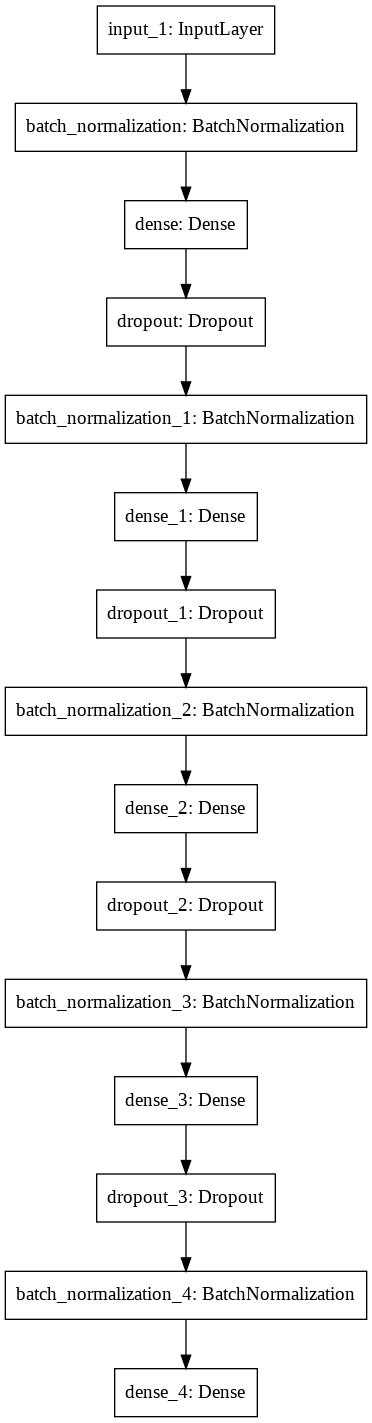


Epoch 00001: val_auc improved from -inf to 0.50749, saving model to best.weights.MLP.hdf5

Epoch 00002: val_auc improved from 0.50749 to 0.50991, saving model to best.weights.MLP.hdf5

Epoch 00003: val_auc improved from 0.50991 to 0.51162, saving model to best.weights.MLP.hdf5

Epoch 00004: val_auc improved from 0.51162 to 0.51189, saving model to best.weights.MLP.hdf5

Epoch 00005: val_auc improved from 0.51189 to 0.51275, saving model to best.weights.MLP.hdf5

Epoch 00006: val_auc improved from 0.51275 to 0.51394, saving model to best.weights.MLP.hdf5

Epoch 00007: val_auc improved from 0.51394 to 0.51486, saving model to best.weights.MLP.hdf5

Epoch 00008: val_auc improved from 0.51486 to 0.51579, saving model to best.weights.MLP.hdf5

Epoch 00009: val_auc improved from 0.51579 to 0.51592, saving model to best.weights.MLP.hdf5

Epoch 00010: val_auc improved from 0.51592 to 0.51705, saving model to best.weights.MLP.hdf5

Epoch 00011: val_auc improved from 0.51705 to 0.51790, saving 

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model


model = create_model(optimizer = 'adam')
#print model structure
model.summary()
display(plot_model(model))

#use call hcak pint to save the best performed model in val_AUC
from keras.callbacks import ModelCheckpoint
checkpoint_filepath="best.weights.MLP.hdf5"
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_auc', verbose=1, save_best_only=True,mode='max')

batch_size = 4096
history = model.fit(Xtrain, Ytrain, 
                    validation_data=(Xtest,Ytest), 
                    epochs = 150,
                    batch_size=batch_size,
                    verbose=0, 
                    callbacks=[checkpoint])


##MLP Model Evualuation NN

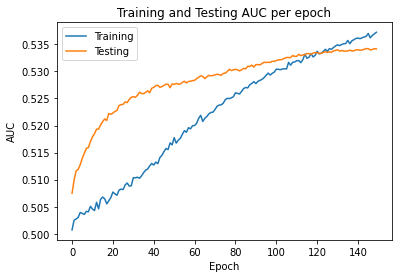

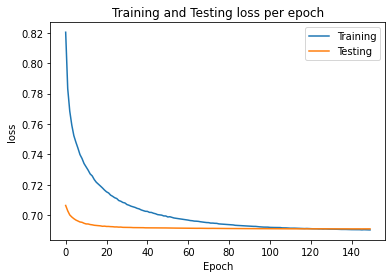

In [ ]:
plt.figure()
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Training and Testing AUC per epoch')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training','Testing'])
plt.show()

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Testing loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(['Training','Testing'])
plt.show()

In [ ]:
#make a perdiction based on Xtest using the best trained model
history.model.load_weights("best.weights.MLP.hdf5")
Ypred_nn = history.model.predict(x = Xtest, batch_size = batch_size, verbose = 1, use_multiprocessing=True)


60/60 [==============================] - 1s 9ms/step


In [ ]:
#label prediction result for evaluation
for i in range(len(Ypred_nn)):
    if (Ypred_nn[i]>0.5): Ypred_nn[i] = 1
    else: Ypred_nn[i] = 0


from sklearn.metrics import f1_score, classification_report, accuracy_score, roc_auc_score
Ytest=Ytest.reset_index(drop=True)

#Evaluate prediction result with Ytest
#We used accuracy score in the code for evalution but didnt include it in our final report. 
#We think accuracy score doesnt represent the performence of our model properly
print(classification_report(Ytest, Ypred_nn))
print(accuracy_score(Ytest, Ypred_nn))
print(f1_score(Ytest, Ypred_nn))
print(roc_auc_score(Ytest, Ypred_nn))

              precision    recall  f1-score   support

           0       0.52      0.60      0.56    121391
           1       0.53      0.45      0.48    120743

    accuracy                           0.52    242134
   macro avg       0.52      0.52      0.52    242134
weighted avg       0.52      0.52      0.52    242134

0.5240445373223092
0.4839999462709823
0.5238406001761583


#LSTM Model

##Preprocess data for LSTM model

In [ ]:
# LSTM expects 3D input (examples, timestep, features)
print("data shape before processing: ", Xtrain.shape, Xtest.shape)
Xtrain_lstm = Xtrain.values.reshape((Xtrain.shape[0], 1, Xtrain.shape[1]))
Xtest_lstm = Xtest.values.reshape((Xtest.shape[0], 1, Xtest.shape[1]))
print("data shape after processing: ", Xtrain_lstm.shape, Xtest_lstm.shape)


data shape before processing:  (1620434, 131) (242134, 131)
data shape after processing:  (1620434, 1, 131) (242134, 1, 131)


##Creare LSTM Model

In [ ]:
from keras.layers import Bidirectional, LSTM

def create_lstm_model(optimizer = 'rmsprop', ):
  with strategy.scope():
    input_seq = Input(shape=(Xtrain_lstm.shape[1], Xtrain_lstm.shape[2], ))

    x = BatchNormalization()(input_seq)
    x = LSTM(160, activation = 'swish', return_sequences=True)(x)
    x = Dropout(0.2)(x)

    x = BatchNormalization()(x)
    x = LSTM(160, activation = 'swish', return_sequences=True)(x)
    x = Dropout(0.2)(x)

    x = BatchNormalization()(x)
    x = LSTM(160, activation = 'swish', return_sequences=True)(x)
    x = Dropout(0.2)(x)

    x = BatchNormalization()(x)
    x = LSTM(160, activation = 'swish', return_sequences=True)(x)
    x = Dropout(0.2)(x)

    x = BatchNormalization()(x)
    output_seq = Dense(1, activation= 'sigmoid')(x)

    model_class = Model(input_seq,output_seq)
    model_class.compile(optimizer = Adam(learning_rate = 1E-5), 
                        loss=BinaryCrossentropy(label_smoothing=1e-2), 
                        metrics=['AUC'])
  return model_class

##Train LSTM Model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 131)]             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 131)               524       
_________________________________________________________________
dense (Dense)                (None, 160)               21120     
_________________________________________________________________
dropout (Dropout)            (None, 160)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 160)               640       
_________________________________________________________________
dense_1 (Dense)              (None, 160)               25760     
_________________________________________________________________
dropout_1 (Dropout)          (None, 160)               0     

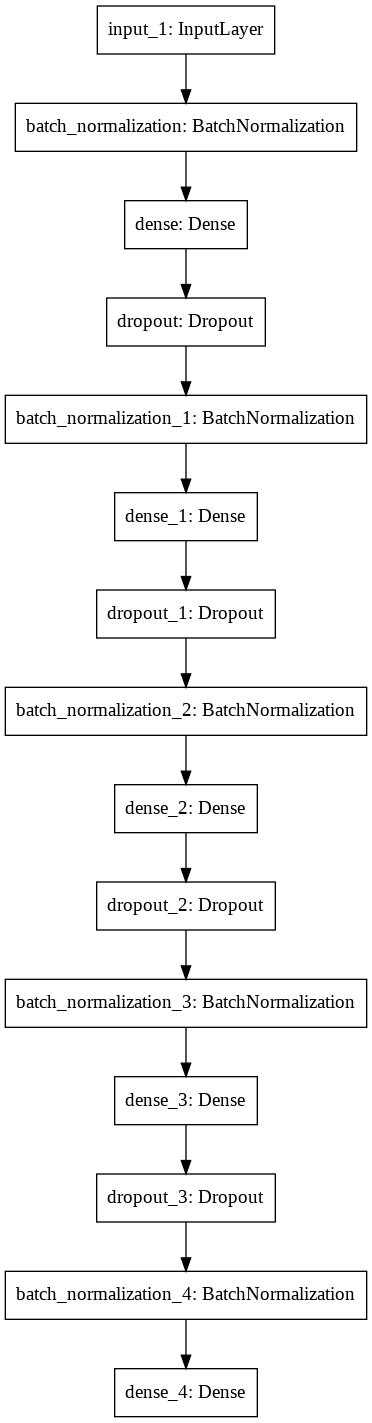


Epoch 00001: val_auc improved from -inf to 0.50345, saving model to best.weights.lstm.hdf5

Epoch 00002: val_auc improved from 0.50345 to 0.50928, saving model to best.weights.lstm.hdf5

Epoch 00003: val_auc improved from 0.50928 to 0.51050, saving model to best.weights.lstm.hdf5

Epoch 00004: val_auc improved from 0.51050 to 0.51208, saving model to best.weights.lstm.hdf5

Epoch 00005: val_auc improved from 0.51208 to 0.51227, saving model to best.weights.lstm.hdf5

Epoch 00006: val_auc improved from 0.51227 to 0.51419, saving model to best.weights.lstm.hdf5

Epoch 00007: val_auc improved from 0.51419 to 0.51442, saving model to best.weights.lstm.hdf5

Epoch 00008: val_auc improved from 0.51442 to 0.51470, saving model to best.weights.lstm.hdf5

Epoch 00009: val_auc improved from 0.51470 to 0.51506, saving model to best.weights.lstm.hdf5

Epoch 00010: val_auc improved from 0.51506 to 0.51523, saving model to best.weights.lstm.hdf5

Epoch 00011: val_auc improved from 0.51523 to 0.5162

In [ ]:

batch_size = 4096
model_lstm = create_lstm_model(optimizer = 'adam')

#print LSTM model structure
model.summary()
display(plot_model(model))

#save best model weight using call back
checkpoint_filepath="best.weights.lstm.hdf5"
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_auc', verbose=1, save_best_only=True,mode='max')

history_lstm = model_lstm.fit(x=Xtrain_lstm, y=Ytrain, 
                    validation_data=(Xtest_lstm,Ytest), 
                    epochs = 150,
                    batch_size=batch_size,
                    verbose=0,
                    callbacks=[checkpoint])

##LSTM Model Evaluation

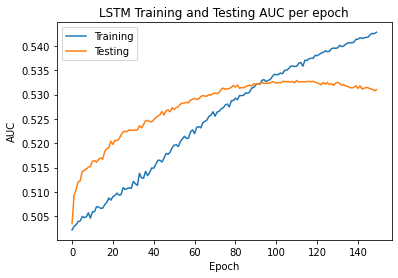

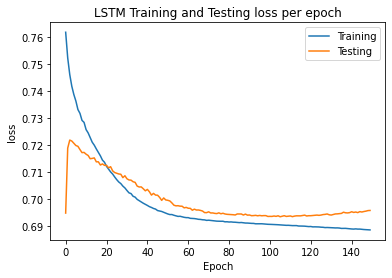

In [ ]:
plt.figure()
plt.plot(history_lstm.history['auc'])
plt.plot(history_lstm.history['val_auc'])
plt.title('LSTM Training and Testing AUC per epoch')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training','Testing'])
plt.show()

plt.figure()
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('LSTM Training and Testing loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(['Training','Testing'])
plt.show()

In [ ]:
#make a perdiction based on Xtest using the best trained model
history_lstm.model.load_weights("best.weights.lstm.hdf5")
Ypred_lstm = history_lstm.model.predict(x = Xtest_lstm, batch_size = 4096, verbose = 1, use_multiprocessing=True)

60/60 [==============================] - 1s 10ms/step


In [ ]:
#label prediction result for evaluation
for i in range(len(Ypred_lstm)):
    if (Ypred_lstm[i]>0.5): Ypred_lstm[i] = 1
    else: Ypred_lstm[i] = 0


Ypred_lstm_shaped = Ypred_lstm.reshape((Ypred_lstm.shape[0],))
pred_action_df = pd.DataFrame(data = Ypred_lstm_shaped, dtype = np.int8)

Ytest=Ytest.reset_index(drop=True)


print(classification_report(Ytest, pred_action_df))
print(accuracy_score(Ytest, pred_action_df))
print(f1_score(Ytest, pred_action_df))
print(roc_auc_score(Ytest, pred_action_df))

              precision    recall  f1-score   support

           0       0.52      0.56      0.54    121391
           1       0.52      0.48      0.50    120743

    accuracy                           0.52    242134
   macro avg       0.52      0.52      0.52    242134
weighted avg       0.52      0.52      0.52    242134

0.522000214757118
0.500991635767871
0.5218912826332015


#Decision Tree Model

In [ ]:
from sklearn.tree import DecisionTreeClassifier

#variable name was created for random forest, now it is used as decision tree as other teammate developed model for decision tree
#hyperparameters are set using the result from hyerparameter tunning

ran = DecisionTreeClassifier(criterion = 'gini', max_depth = 7)
ran.fit(Xtrain, Ytrain)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
Ypred_rf = ran.predict(Xtest)

#label prediction result for evaluation
for i in range(len(Ypred_rf)):
    if (Ypred_rf[i]>0.5): Ypred_rf[i] = 1
    else: Ypred_rf[i] = 0

#Evaluaiton Result
print(classification_report(Ytest, Ypred_rf))
print(accuracy_score(Ytest, Ypred_rf))
print(f1_score(Ytest, Ypred_rf))
print(roc_auc_score(Ytest, Ypred_rf))

              precision    recall  f1-score   support

           0       0.51      0.35      0.41    121391
           1       0.50      0.67      0.57    120743

    accuracy                           0.51    242134
   macro avg       0.51      0.51      0.49    242134
weighted avg       0.51      0.51      0.49    242134

0.5063394649243808
0.5744465726308893
0.5067714038246325


#Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(n_jobs = -1, verbose = 1)
logistic_model.fit(Xtrain, Ytrain)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.1min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

In [ ]:
Ypred_lr = logistic_model.predict(Xtest)

#label prediction result for evaluation
for i in range(len(Ypred_lr)):
    if (Ypred_lr[i]>0.5): Ypred_lr[i] = 1
    else: Ypred_lr[i] = 0


#Evaluaiton Result
print(classification_report(Ytest, Ypred_lr))
print(accuracy_score(Ytest, Ypred_lr))
print(f1_score(Ytest, Ypred_lr))
print(roc_auc_score(Ytest, Ypred_lr))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00    121391
           1       0.50      1.00      0.67    120743

    accuracy                           0.50    242134
   macro avg       0.25      0.50      0.33    242134
weighted avg       0.25      0.50      0.33    242134

0.4986618979573294
0.6654761806342093
0.5


#Competition Score

##Generate Action Prediction Data Frame Based on test data

In [ ]:

#generate action data for evaluation 
#if (resp = 1): action = 1, else: action = 0
#take a test_df data frame(generated in preprocessing) and resp ndarray from prediction
#return a full test data frame for score and evaluation

def generate_action_df (test_df, Y):
  action = []
  for i in range(len(Y)):
    if ((Y[i]>0.5)): action.append(1)
    else: action.append(0)
  action_np = np.asarray(a = action)

  action_df = test_df.drop(['action'], axis = 1)
  action_df = action_df.reset_index(drop = True)
  action_df.insert(loc = 0, column = 'action', value = action_np)

  return action_df

pred_lstm_df = generate_action_df(test_df = test_df, Y = Ypred_lstm)
pred_nn_df = generate_action_df(test_df = test_df, Y = Ypred_nn)
pred_rf_df = generate_action_df(test_df = test_df, Y = Ypred_rf)
pred_lr_df = generate_action_df(test_df = test_df, Y = Ypred_lr)


##Scoring Perfiction Result (Same as competition)

In [ ]:
# score for both test and perdiction for comparsion
#Refernce: This function is the same one RpyGamer implemented in a post, we decied to use it as we will end up coding the same logic
#Website: https://www.kaggle.com/c/jane-street-market-prediction/discussion/200207
def utility_scoring(df):
    """
    To get the utility score used in the challenge. From Kaggle
    """
    from math import sqrt
    u = 0
    Pi = []
    Pis = []
    count_i = len(df['date'].unique())
    for i in list(df['date'].unique()):
        tmp = df[df['date'] == i][["date","weight","resp","action"]]
        tmp["mult"] = tmp['weight'] * tmp['resp'] * tmp['action']
        Pi.append(tmp["mult"].sum())
        Pis.append((tmp["mult"].sum())**2)
    
    t =  sum(Pi)/sqrt(sum(Pis)) * sqrt(250/count_i)
    u = min(max(t,0),6)*sum(Pi)
    return u

print('Competition Scores: ')
print("LSTM score: ", utility_scoring(pred_lstm_df))
print("MLP score: ", utility_scoring(pred_nn_df))
print("Decision Tree score: ", utility_scoring(pred_rf_df))
print("Logistic Regression score: ", utility_scoring(pred_lr_df))

Competition Scores: 
LSTM score:  1854.6054504227995


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


MLP score:  1801.4465758857527
Decision Tree score:  925.4264101354539
Logistic Regression score:  56.691763100027885
